# Visualize Discriminator

In [1]:
import torch
from methods.cgan import Generator, Discriminator
from robot import TwoLinkRobotIK

# Load the model
latent_size = 2
hidden_size = 64
output_size = 2
condition_size = 2

generator = Generator(latent_size, hidden_size, output_size, condition_size)
# generator.load_state_dict(torch.load('logs/cgan_model_gradient_data/cgan_model_gradient_data.pth', weights_only=True))
generator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/generator_gradient_data_rs.pth', weights_only=True))
# generator.load_state_dict(torch.load('logs/cgan_model_incremental_data/generator_incremental_data.pth', weights_only=True))
# generator.load_state_dict(torch.load('logs/cgan_training_replace/generator_4.pt', weights_only=True))
generator.eval()

discriminator = Discriminator(output_size, hidden_size, 1, condition_size)
discriminator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/discriminator_gradient_data_rs.pth', weights_only=True))

# Load the robot
# Robot parameters
L1 = 3.0  # Length of link 1
L2 = 3.0  # Length of link 2

# Create the robot
robot = TwoLinkRobotIK(L1, L2)


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming the classes TwoLinkRobotIK and Discriminator are already defined and imported

def plot_robot_and_heatmap(robot, discriminator, angles, grid_size=100):
    # Unpack angles
    theta1, theta2 = angles

    # Generate grid points within the workspace
    x_range = np.linspace(-robot.link1_length - robot.link2_length, robot.link1_length + robot.link2_length, grid_size)
    y_range = np.linspace(-robot.link1_length - robot.link2_length, robot.link1_length + robot.link2_length, grid_size)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

    # Compute discriminator output for each grid point
    discriminator_outputs = []
    for point in grid_points:
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        angles_tensor = torch.tensor(angles, dtype=torch.float32).unsqueeze(0)
        output = discriminator(angles_tensor, point_tensor).detach()
        discriminator_outputs.append(output.item())

    # Reshape the outputs to match the grid
    discriminator_outputs = np.array(discriminator_outputs).reshape(grid_size, grid_size)

    # Plot the robot and heatmap on the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(discriminator_outputs, extent=(x_range.min(), x_range.max(), y_range.min(), y_range.max()), origin='lower', cmap=cm.coolwarm, alpha=0.6)
    plt.colorbar(heatmap, ax=ax, label='Discriminator Output')

    # Plot the robot
    # Compute joint positions using numpy
    joint1 = (robot.link1_length * np.cos(theta1),
              robot.link1_length * np.sin(theta1))
    end_effector = (
        joint1[0] + robot.link2_length * np.cos(theta1 + theta2),
        joint1[1] + robot.link2_length * np.sin(theta1 + theta2),
    )

    # Plot the robot arm
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', color='black')
    ax.set_xlim(-robot.link1_length - robot.link2_length - 1, robot.link1_length + robot.link2_length + 1)
    ax.set_ylim(-robot.link1_length - robot.link2_length - 1, robot.link1_length + robot.link2_length + 1)
    ax.set_aspect('equal', adjustable='box')

    ax.set_title('Robot and Discriminator Output Heatmap')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    plt.show()

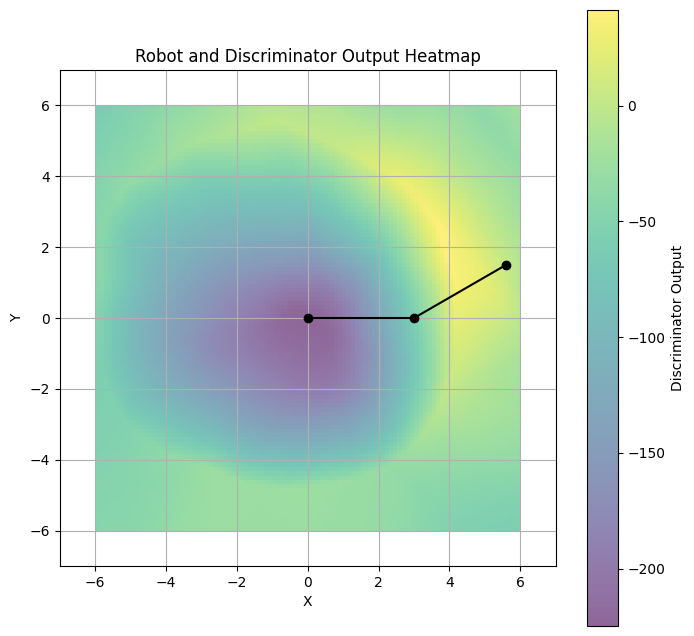

(np.float64(0.5235987755982985), np.float64(-0.523598775598298))


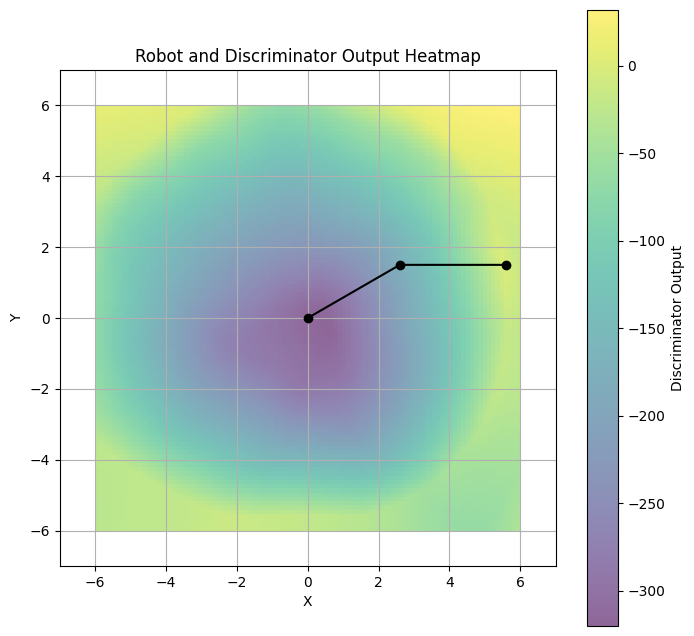

In [15]:
# Given angles
angles = (0, np.pi/6)  # Example angles

# Plot the robot and heatmap
plot_robot_and_heatmap(robot, discriminator, angles)

# Calculate the conjugate angle such that the target is the same
conjugate_angles = robot.get_conjugate_angles(angles)
print(conjugate_angles)

plot_robot_and_heatmap(robot, discriminator, conjugate_angles)

# Illustration of the idea

## Hyperbola Example

In [2]:
# utility 
import numpy as np
import matplotlib.pyplot as plt

# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper


True


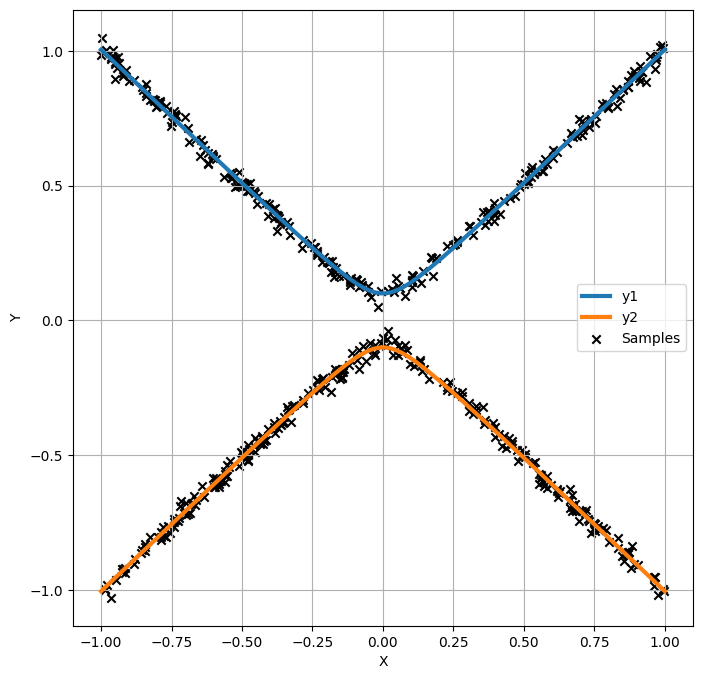

In [89]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola

# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()



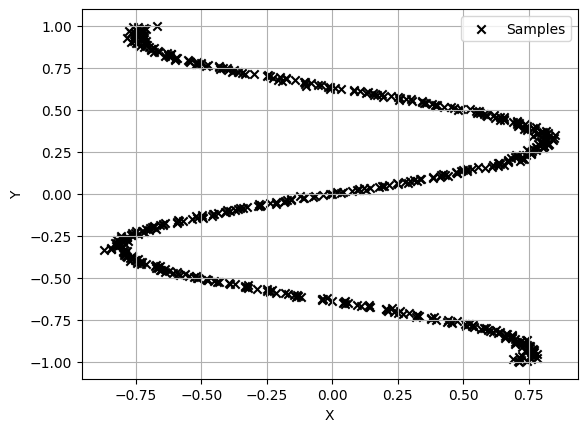

In [ ]:
# Another way to generate data of multi-valued function

# num_samples = 500
# y = np.linspace(-1, 1, num_samples)
# x = 0.8 * np.sin(5 * y) + 0.05 * y  + 0.02 * np.random.randn(*y.shape)

# # plt.hist2d(x, y, bins=35)
# # plt.xlim(-8, 8)
# # plt.ylim(-1, 1)
# # plt.axis('off')

# plt.scatter(x, y, marker='x', color='black', label='Samples')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.grid()
# plt.legend()
# plt.show()


In [4]:
# Train A MLP model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

def train(model, dataloader, criterion, optimizer, scheduler, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            positions = batch_x
            angles = batch_y
            
            outputs = model(positions)
            loss = criterion(outputs, angles)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

# Hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
batch_size = 32
learning_rate = 0.001

# Prepare the dataset and dataloader
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Initialize model, criterion and optimizer
mlp = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# Train the model
train(mlp, dataloader, criterion, optimizer, scheduler, num_epochs)

Epoch [1/100], Loss: 0.3417, LR: 0.001000
Epoch [2/100], Loss: 0.3412, LR: 0.001000
Epoch [3/100], Loss: 0.3388, LR: 0.001000
Epoch [4/100], Loss: 0.3400, LR: 0.001000
Epoch [5/100], Loss: 0.3340, LR: 0.001000
Epoch [6/100], Loss: 0.3366, LR: 0.001000
Epoch [7/100], Loss: 0.3364, LR: 0.001000
Epoch [8/100], Loss: 0.3349, LR: 0.001000
Epoch [9/100], Loss: 0.3343, LR: 0.001000
Epoch [10/100], Loss: 0.3383, LR: 0.001000
Epoch [11/100], Loss: 0.3390, LR: 0.001000
Epoch [12/100], Loss: 0.3386, LR: 0.001000
Epoch [13/100], Loss: 0.3363, LR: 0.001000
Epoch [14/100], Loss: 0.3378, LR: 0.001000
Epoch [15/100], Loss: 0.3346, LR: 0.001000
Epoch [16/100], Loss: 0.3380, LR: 0.001000
Epoch [17/100], Loss: 0.3363, LR: 0.001000
Epoch [18/100], Loss: 0.3343, LR: 0.001000
Epoch [19/100], Loss: 0.3361, LR: 0.001000
Epoch [20/100], Loss: 0.3375, LR: 0.001000
Epoch [21/100], Loss: 0.3310, LR: 0.001000
Epoch [22/100], Loss: 0.3353, LR: 0.001000
Epoch [23/100], Loss: 0.3358, LR: 0.001000
Epoch [24/100], Loss

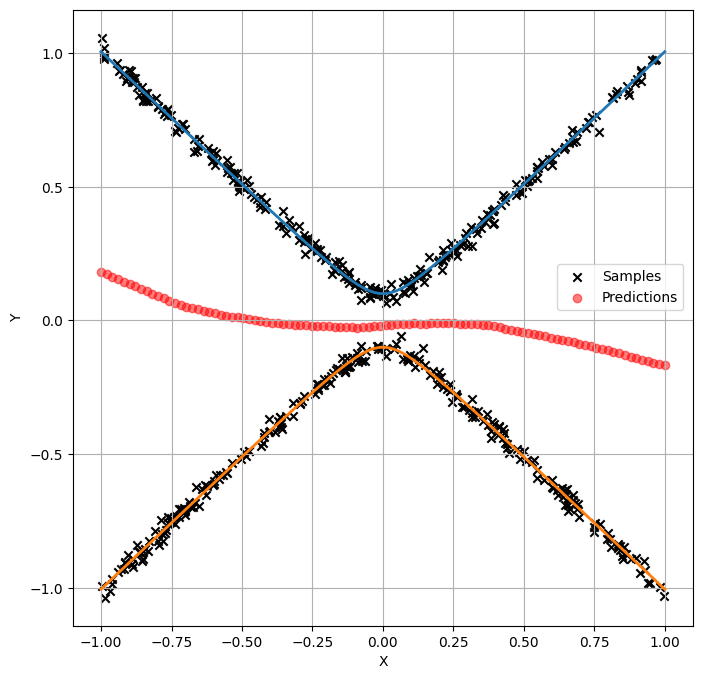

In [75]:
# Random sample the query points and get the predictions
num_query_points = 100
# query_points = np.random.uniform(-1, 1, num_query_points)
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
predictions = mlp(query_points_tensor).detach().numpy()


# Plot the function, samples, and predictions
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(0.77, 0.55))
plt.savefig('asset/proposal/hyperbola_mlp.png', dpi = 300)
plt.show()

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse

# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# Discriminator modified to output raw logits instead of sigmoid
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            # Removed sigmoid to get raw logits
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

def compute_discriminator_loss(discriminator, real_samples, fake_samples, condition):
    """Compute discriminator loss using log probabilities as per the formula"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)
    
    # Compute log probabilities
    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)  # Add small epsilon to prevent log(0)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)
    
    # Average over batch
    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))
    
    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))

def compute_generator_loss(discriminator, fake_samples, condition):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples, condition)
    loss = -torch.mean(torch.log(torch.sigmoid(d_fake) + 1e-10))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            position = batch_x
            angles = batch_y
            
            # Step 1: Update discriminator
            for _ in range(30):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(position.size(0), generator.latent_size)
                
                # Generate fake samples
                fake_angles = generator(z, position)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, angles, fake_angles.detach(), position
                )
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Step 2 & 3: Update generator
            z = torch.randn(position.size(0), generator.latent_size)
            fake_angles = generator(z, position)
            g_loss = compute_generator_loss(discriminator, fake_angles, position)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")



    
# Hyperparameters
latent_size = 0
hidden_size = 64
output_size = 1
condition_size = 1
num_epochs = 200
batch_size = 100
learning_rate_d = 0.0002
learning_rate_g = 0.00005

# Prepare the dataset and dataloader
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(latent_size, hidden_size, output_size, condition_size)
discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

Epoch [1/200], Discriminator Loss: 0.3672, Generator Loss: 2.1156
Epoch [2/200], Discriminator Loss: 0.1073, Generator Loss: 4.1809
Epoch [3/200], Discriminator Loss: 0.2352, Generator Loss: 4.0591
Epoch [4/200], Discriminator Loss: 0.2404, Generator Loss: 2.7139
Epoch [5/200], Discriminator Loss: 0.1598, Generator Loss: 3.6592
Epoch [6/200], Discriminator Loss: 0.1575, Generator Loss: 3.6261
Epoch [7/200], Discriminator Loss: 0.0972, Generator Loss: 4.1136
Epoch [8/200], Discriminator Loss: 0.1425, Generator Loss: 4.0173
Epoch [9/200], Discriminator Loss: 0.0955, Generator Loss: 4.4785
Epoch [10/200], Discriminator Loss: 0.1144, Generator Loss: 4.0391
Epoch [11/200], Discriminator Loss: 0.1243, Generator Loss: 3.9955
Epoch [12/200], Discriminator Loss: 0.1115, Generator Loss: 4.2747
Epoch [13/200], Discriminator Loss: 0.1313, Generator Loss: 4.1031
Epoch [14/200], Discriminator Loss: 0.1858, Generator Loss: 3.7187
Epoch [15/200], Discriminator Loss: 0.2919, Generator Loss: 2.8732
Epoc

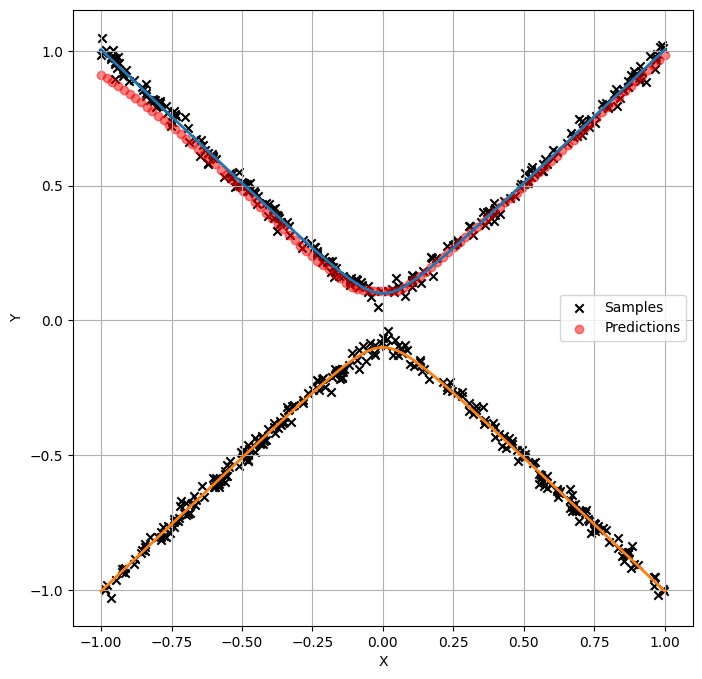

In [102]:
# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions = generator(z, query_points_tensor).detach().numpy()

# Plot the function, samples, and predictions
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]

# Plot the function, samples, and predictions
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()


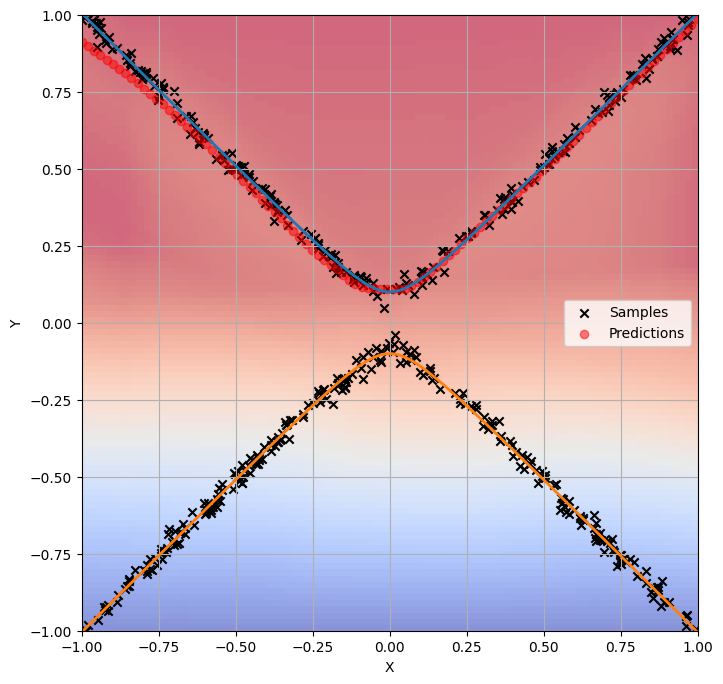

In [103]:
# Visualize the discriminator output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Compute discriminator output for each grid point
discriminator_outputs = []
for point in grid_points:
    x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
    y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
    output = discriminator(y_plot, x_plot).detach()
    # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
    discriminator_outputs.append(output.item())

# Reshape the outputs to match the grid
discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
# Normalize every column of the heatmap
discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

# As energy, take minus of the discriminator output
discriminator_outputs = -discriminator_outputs

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)


# Plot the function
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

for i, y_val in enumerate(y_vals_transposed):
    ax.plot(x_vals, y_val,  linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()




Epoch [1/100], Generator Loss: 15.4823
Epoch [2/100], Generator Loss: 15.8793
Epoch [3/100], Generator Loss: 12.9957
Epoch [4/100], Generator Loss: 14.2326
Epoch [5/100], Generator Loss: 14.9266
Epoch [6/100], Generator Loss: 13.4863
Epoch [7/100], Generator Loss: 13.9801
Epoch [8/100], Generator Loss: 12.1906
Epoch [9/100], Generator Loss: 12.8771
Epoch [10/100], Generator Loss: 13.6473
Epoch [11/100], Generator Loss: 12.4831
Epoch [12/100], Generator Loss: 11.6116
Epoch [13/100], Generator Loss: 12.3286
Epoch [14/100], Generator Loss: 12.8052
Epoch [15/100], Generator Loss: 12.7550
Epoch [16/100], Generator Loss: 12.7605
Epoch [17/100], Generator Loss: 12.1979
Epoch [18/100], Generator Loss: 11.0137
Epoch [19/100], Generator Loss: 10.7035
Epoch [20/100], Generator Loss: 10.4528
Epoch [21/100], Generator Loss: 9.7426
Epoch [22/100], Generator Loss: 11.1604
Epoch [23/100], Generator Loss: 8.7920
Epoch [24/100], Generator Loss: 9.8136
Epoch [25/100], Generator Loss: 8.9584
Epoch [26/100

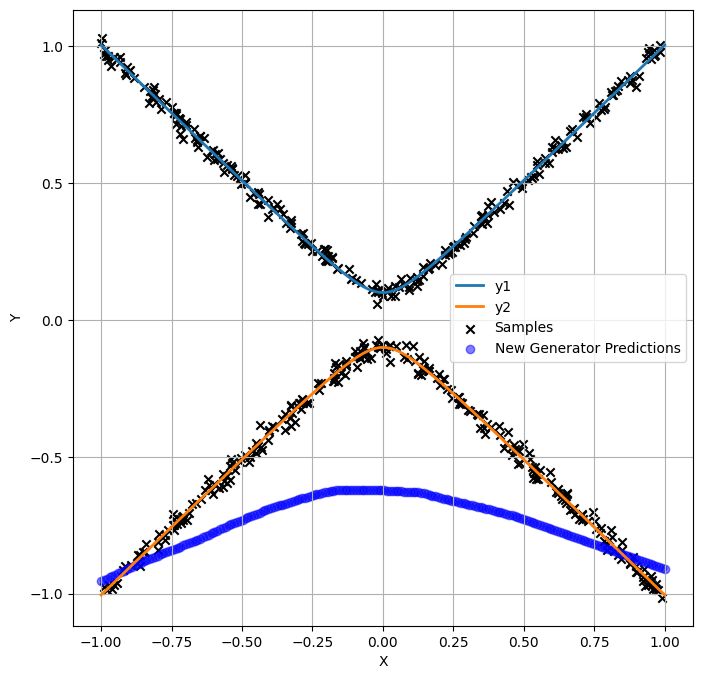

In [15]:
# Fix the discriminator and train a new generator
# Fix the discriminator parameters
for param in discriminator.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        position = batch_x
        angles = batch_y
        
        # Draw noise samples
        z = torch.randn(position.size(0), new_generator.latent_size)
        
        # Generate fake samples
        fake_angles = new_generator(z, position)
        
        # Compute generator loss
        g_loss = compute_generator_loss(discriminator, fake_angles, position)
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")
    
    
# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions_new = new_generator(z, query_points_tensor).detach().numpy()

# Plot the function, samples, and predictions from new_generator
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Energy-based Model using MLP
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    counter_samples = [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min for _ in range(neg_count)]
    return counter_samples

# Training loop
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            positions = batch_x.to(device)
            angles = batch_y.to(device)
            
            counter_samples = generate_counter_samples(y_min, y_max, positions.size(0), neg_count, device)
            
            # Compute loss
            loss = criterion(model, positions, angles, counter_samples)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
# Hyperparameters
input_size = 1  # x, y positions
action_size = 1  # joint angles
hidden_size = 64
num_epochs = 100
batch_size = 32
neg_count = 256
learning_rate = 0.001

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint angle limits (radians)
y_max = torch.tensor([1])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Load dataset
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)
optimizer = optim.Adam(energy_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Train the model
train(energy_model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Loss: 5.5407, LR: 0.001000
Epoch [2/100], Loss: 5.5210, LR: 0.001000
Epoch [3/100], Loss: 5.5012, LR: 0.001000
Epoch [4/100], Loss: 5.4770, LR: 0.001000
Epoch [5/100], Loss: 5.4466, LR: 0.001000
Epoch [6/100], Loss: 5.4091, LR: 0.001000
Epoch [7/100], Loss: 5.3629, LR: 0.001000
Epoch [8/100], Loss: 5.3042, LR: 0.001000
Epoch [9/100], Loss: 5.2413, LR: 0.001000
Epoch [10/100], Loss: 5.1692, LR: 0.001000
Epoch [11/100], Loss: 5.0894, LR: 0.001000
Epoch [12/100], Loss: 5.0198, LR: 0.001000
Epoch [13/100], Loss: 4.9490, LR: 0.001000
Epoch [14/100], Loss: 4.8734, LR: 0.001000
Epoch [15/100], Loss: 4.8153, LR: 0.001000
Epoch [16/100], Loss: 4.7594, LR: 0.001000
Epoch [17/100], Loss: 4.6875, LR: 0.001000
Epoch [18/100], Loss: 4.6389, LR: 0.001000
Epoch [19/100], Loss: 4.5823, LR: 0.001000
Epoch [20/100], Loss: 4.5368, LR: 0.000500
Epoch [21/100], Loss: 4.4860, LR: 0.000500
Epoch [22/100], Loss: 4.4515, LR: 0.000500
Epoch [23/100], Loss: 4.4295, LR: 0.000500
Epoch [24/100], Loss

In [97]:
import torch

# Derivative-free optimizer for inference
def ebm_infer(energy_model, target_position, y_min, y_max, samples=16384, iterations=4, sigma_init=0.33, scale=0.5):
    """
    Find angles that minimize energy for a given target position.

    Args:
        energy_model: Trained energy-based model.
        target_position: Target position (Cartesian coordinates), shape: (1, input_dim).
        y_min: Minimum values for joint angles (tensor).
        y_max: Maximum values for joint angles (tensor).
        samples: Number of random samples for initial exploration.
        iterations: Number of optimization iterations.
        sigma_init: Initial noise level for exploration.
        scale: Scaling factor for noise reduction.

    Returns:
        Optimal joint angles minimizing the energy.
    """
    device = target_position.device
    target_position = target_position.repeat(samples, 1)  # Repeat for batch inference
    sigma = sigma_init

    # Initialize random joint angle samples
    angles = torch.rand((samples, y_min.size(-1)), device=device) * (y_max - y_min) + y_min

    for _ in range(iterations):
        # Compute energies for current samples
        # If energy_model is type EnergyModel, you can use energy_model(target_position, angles)
        # elif energy_model is typr Discriminator, you can use -energy_model(angles, target_position)
        if isinstance(energy_model, EnergyModel):
            energies = energy_model(target_position, angles)
        elif isinstance(energy_model, Discriminator):
            energies = -energy_model(angles, target_position)
        else:
            raise ValueError("Invalid energy model type.")

        # Softmax over negative energies for sampling probabilities
        probabilities = torch.softmax(-energies, dim=0)

        # Resample based on probabilities
        indices = torch.multinomial(probabilities, num_samples=samples, replacement=True)
        angles = angles[indices]

        # Add noise for exploration
        angles += torch.randn_like(angles) * sigma
        angles = torch.clamp(angles, y_min, y_max)  # Clamp to valid joint angle bounds

        # Reduce noise scale
        sigma *= scale

    # Return the angles corresponding to the minimum energy
    best_idx = torch.argmin(energies)
    return angles[best_idx].unsqueeze(0)  # Shape: (1, action_dim)


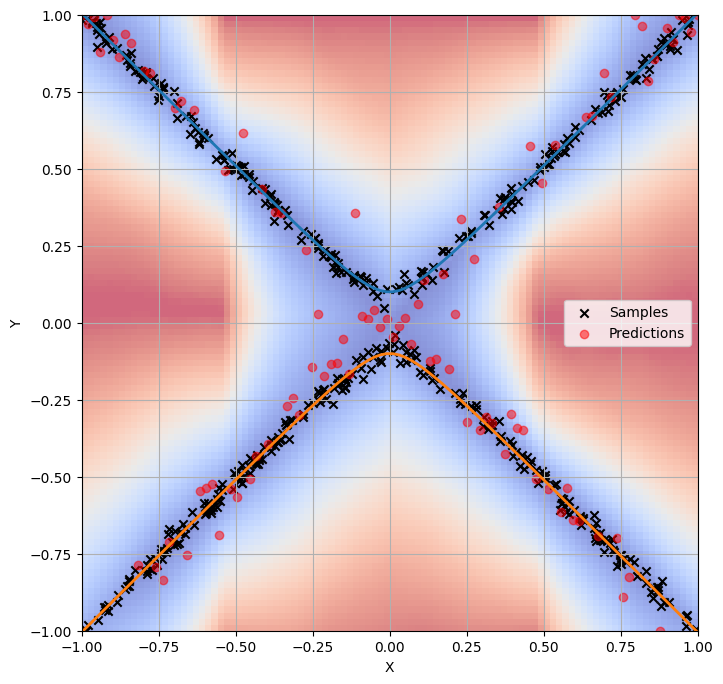

In [98]:

# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)

predictions = []
for point in query_points:
    query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
    prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
    predictions.append(prediction.item())


# Visualize the energy model output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# Plot the function
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

for i, y_val in enumerate(y_vals_transposed):
    ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
plt.show()




---

## Two Link Robot Example

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from robot import TwoLinkRobotIK
from methods.mlp import MLP
from methods.cgan import Generator
from methods.cvae import CVAE 
from methods.reinforce import PolicyNetwork
from methods.ibc import EnergyModel
from utils import ebm_infer

# Robot parameters
L1 = 3.0  # Length of link 1
L2 = 3.0  # Length of link 2

# Create the robot
robot = TwoLinkRobotIK(L1, L2)

# Hyperparameters
input_size = 2
hidden_size = 64
output_size = 2
latent_size = 2

# cgan and cvae 
condition_size = 2

# cvae
input_dim = 2
latent_dim = 1

def load_model(model_type):
    if model_type == 'mlp':
        model = MLP(input_size, hidden_size, output_size)
        model.load_state_dict(torch.load('logs/mlp_model_gradient_data_rs/mlp_model_gradient_data_rs.pth', weights_only=True))
        model.eval()
        return model
    elif model_type == 'cgan':
        generator = Generator(latent_size, hidden_size, output_size, condition_size)
        generator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/generator_gradient_data_rs.pth', weights_only=True))
        generator.eval()
        return generator
    elif model_type == 'cvae':
        cvae = CVAE(input_dim, condition_size, hidden_size, latent_dim)
        cvae.load_state_dict(torch.load('logs/cvae_model_gradient_data_rs/cvae_model_gradient_data_rs.pth', weights_only=True))
        cvae.eval()
        return cvae
    elif model_type == 'reinforce':
        reinforce_policy_net = PolicyNetwork(input_size, hidden_size, output_size)
        reinforce_policy_net.load_state_dict(torch.load('logs/REINFORCE/reinforce_model.pth', weights_only=True))
        reinforce_policy_net.eval()
        return reinforce_policy_net
    elif model_type == 'ibc':
        energy_model = EnergyModel(input_size=input_size, action_size=output_size, hidden_size=hidden_size)
        energy_model.load_state_dict(torch.load('logs/ibc_model_gradient_data_rs/ibc_model_gradient_data_rs.pth', weights_only=True))
        energy_model.eval()
        energy_model.to('cuda')
        return energy_model
    elif model_type == 'ebgan':
        ebgan_model = Generator(latent_size, hidden_size, output_size, condition_size)
        ebgan_model.load_state_dict(torch.load('logs/ebgan_model_gradient_data_rs/generator_gradient_data_rs.pth', weights_only=True))
        ebgan_model.eval()
        ebgan_model.to('cuda')
        return ebgan_model

def ik_methods(method, target_position):
    if method == 'gradient_descent':
        target_position = [float(target_position[0]), float(target_position[1])]
        return robot.solve_ik_gradient_descent(target_position)
    elif method == 'mlp':
        input_tensor = torch.tensor(target_position, dtype=torch.float32).unsqueeze(0)
        output_tensor = mlp_model(input_tensor)
        return output_tensor[0].detach().numpy()
    elif method == 'cgan':
        latent_vector = torch.randn(1, latent_size)
        condition = torch.tensor(target_position, dtype=torch.float32).unsqueeze(0)
        return cgan_model(latent_vector, condition).detach().numpy()[0]
    elif method == 'cvae':
        condition = torch.tensor(target_position, dtype=torch.float32).unsqueeze(0)
        latent_sample = torch.randn(1, latent_dim)
        return cvae_model.decoder(latent_sample, condition).detach().numpy()[0]
    elif method == 'reinforce':
        input_tensor = torch.tensor(target_position, dtype=torch.float32).unsqueeze(0)
        output_tensor, _ = reinforce_model(input_tensor)
        return output_tensor[0].detach().numpy()
    elif method == 'ibc':
        target_tensor = torch.tensor(target_position, dtype=torch.float32).unsqueeze(0).to('cuda')
        y_min = torch.tensor([-3.14, -3.14], device='cuda')
        y_max = torch.tensor([3.14, 3.14], device='cuda')
        inferred_angles = ebm_infer(energy_model, target_tensor, y_min, y_max)
        return inferred_angles.cpu().numpy()[0]
    elif method == 'ebgan':
        latent_vector = torch.randn(1, latent_size, device='cuda')
        condition = torch.tensor(target_position, dtype=torch.float32).unsqueeze(0).to('cuda')
        return ebgan_model(latent_vector, condition).detach().cpu().numpy()[0]
    else:
        raise ValueError("Invalid method type")

def plot_and_save(method_type, target_position):
    global mlp_model, cgan_model, cvae_model, reinforce_model, energy_model, ebgan_model

    if method_type == 'mlp':
        mlp_model = load_model('mlp')
    elif method_type == 'cgan':
        cgan_model = load_model('cgan')
    elif method_type == 'cvae':
        cvae_model = load_model('cvae')
    elif method_type == 'reinforce':
        reinforce_model = load_model('reinforce')
    elif method_type == 'ibc':
        energy_model = load_model('ibc')
    elif method_type == 'ebgan':
        ebgan_model = load_model('ebgan')

    # Initialize plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-L1 - L2 , L1 + L2 )
    ax.set_ylim(-L1 - L2 , L1 + L2 )
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    # plt.title(f"2-Link Robotic Arm - {method_type.upper()}")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # Add a circle to represent the workspace range
    workspace_circle = plt.Circle((0, 0), L1 + L2, color='gray', fill=False, linestyle='--',linewidth=1.5)
    ax.add_artist(workspace_circle)

    # Create a grid of target positions
    x_range = np.linspace(-L1 - L2, L1 + L2, 100)
    y_range = np.linspace(-L1 - L2, L1 + L2, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    if method_type != 'gradient_descent':  # For all methods except gradient descent
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                target_position_grid = (X[i, j], Y[i, j])
                theta1, theta2 = ik_methods(method_type, target_position_grid)
                Z[i, j] = robot.evaluate(theta1, theta2, target_position_grid[0], target_position_grid[1])

        heatmap = ax.imshow(Z, extent=(-L1 - L2, L1 + L2, -L1 - L2, L1 + L2), origin='lower', cmap='coolwarm', alpha=0.6)

    # Plot the target position
    target_x, target_y = target_position
    ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')

    # Plot the robot
    theta1, theta2 = ik_methods(method_type, target_position)
    joint1 = (L1 * np.cos(theta1), L1 * np.sin(theta1))
    end_effector = (joint1[0] + L2 * np.cos(theta1 + theta2), joint1[1] + L2 * np.sin(theta1 + theta2))
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', label=f'Robot', color='red', alpha = 0.5, linewidth=2.5)
    # Add legend
    ax.legend()
    # Save the plot
    plt.savefig(f'asset/proposal/robot_{method_type}_{target_position[0]}_{target_position[1]}.png')
    plt.show()



/tmp/ipykernel_43032/3039649289.py:146: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


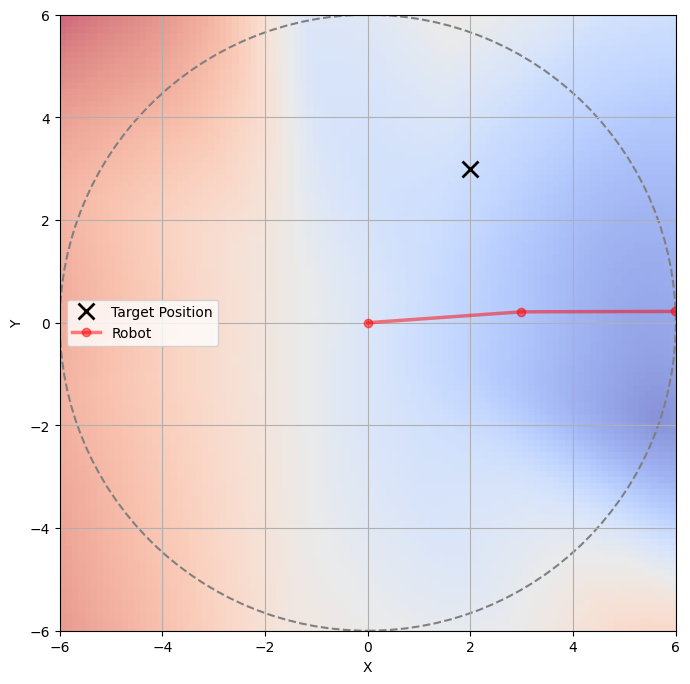

In [4]:
method_type = 'mlp'
target_position = [2.0, 3.0]
plot_and_save(method_type, target_position)

/tmp/ipykernel_43032/3039649289.py:146: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


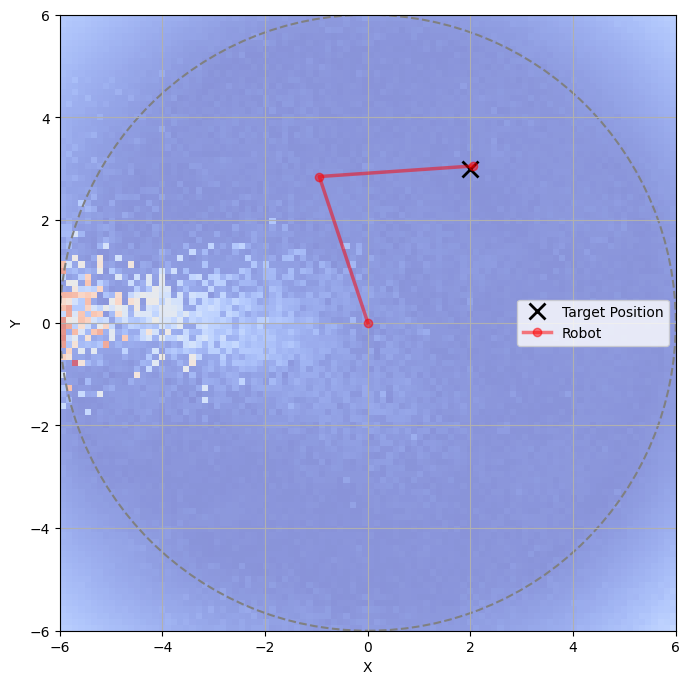

In [5]:
method_type = 'cgan'  # Change this to the desired method
target_position = [2.0, 3.0]  # Change this to the desired target position
plot_and_save(method_type, target_position)

/tmp/ipykernel_43032/3039649289.py:146: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


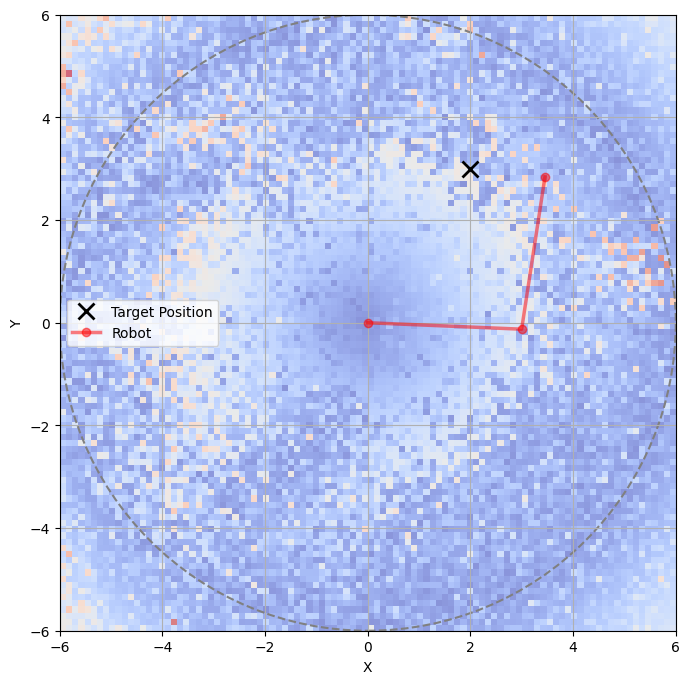

In [6]:
method_type = 'ibc'
target_position = [2.0, 3.0]  # Change this to the desired target position
plot_and_save(method_type, target_position)

/tmp/ipykernel_43032/1290835280.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


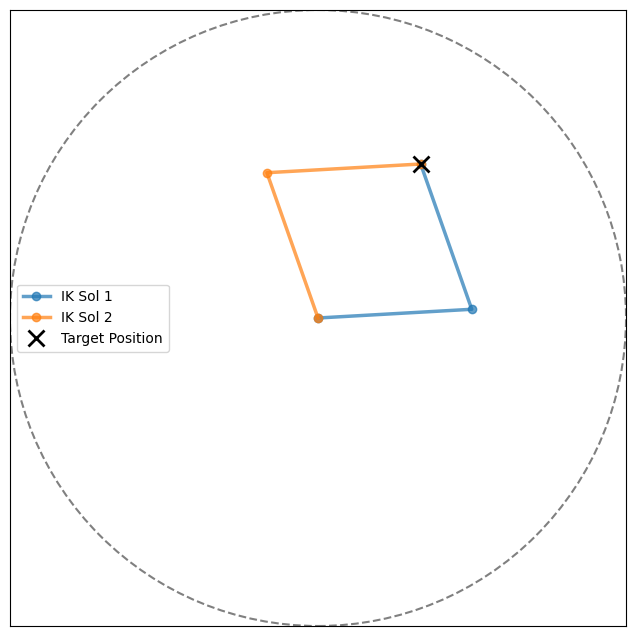

In [10]:
target_position = [2.0, 3.0]
target_x, target_y = target_position
# Solve IK analytically
solutions = robot.solve_ik_analytical(target_x, target_y)

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-L1 - L2 , L1 + L2 )
ax.set_ylim(-L1 - L2 , L1 + L2 )
ax.set_aspect('equal', adjustable='box')

# Hide ticks and axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Add a circle to represent the workspace range
workspace_circle = plt.Circle((0, 0), L1 + L2, color='gray', fill=False, linestyle='--', linewidth=1.5)
ax.add_artist(workspace_circle)

# Plot robot configurations
for i, (theta1, theta2) in enumerate(solutions):
    # Compute joint positions using numpy
    joint1 = (L1 * np.cos(theta1), L1 * np.sin(theta1))
    end_effector = (joint1[0] + L2 * np.cos(theta1 + theta2), joint1[1] + L2 * np.sin(theta1 + theta2))

    # Plot the robot arm
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', label=f'IK Sol {i+1}', alpha=0.7, linewidth=2.5)
    

# Plot the target position
ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')

# Add legend
ax.legend()

plt.savefig(f'asset/proposal/robot_ik_analytical_{target_position[0]}_{target_position[1]}.png')

# Show plot
plt.show()